Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit

Loading dataset

In [2]:
df=pd.read_csv('F:/ML project power consumption/archive/PJME_hourly.csv')

In [3]:
#Printing first 5 records
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
df.shape

(145366, 2)

In [5]:
#Checking for null values in df
df.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

Setting Index as DateTime

In [6]:
df=df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [7]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


Visualising energy

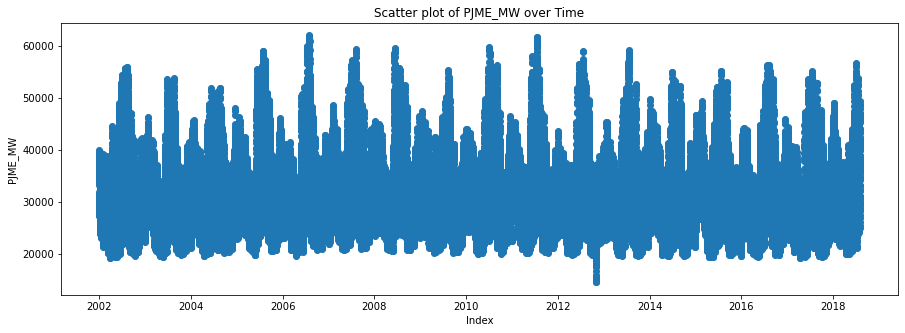

In [8]:
#Plot of Energy Consumption over Time
plt.figure(figsize=(15, 5))
plt.scatter(df.index, df['PJME_MW'])
plt.xlabel('Index')
plt.ylabel('PJME_MW')
plt.title('Scatter plot of PJME_MW over Time')
plt.show()

Visualising one week data

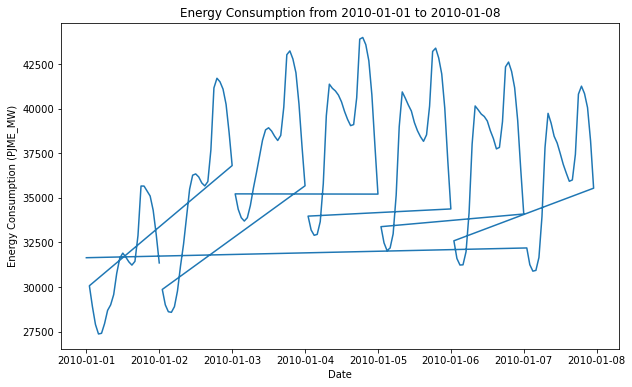

In [9]:
# Filter the data for the specified week
week_data = (df.index >= '2010-01-01') & (df.index < '2010-01-08')
week_data_df = df.loc[week_data]

# Plot the energy consumption
plt.figure(figsize=(10, 6))
plt.plot(week_data_df.index, week_data_df['PJME_MW'])
plt.title('Energy Consumption from 2010-01-01 to 2010-01-08')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (PJME_MW)')
plt.show()


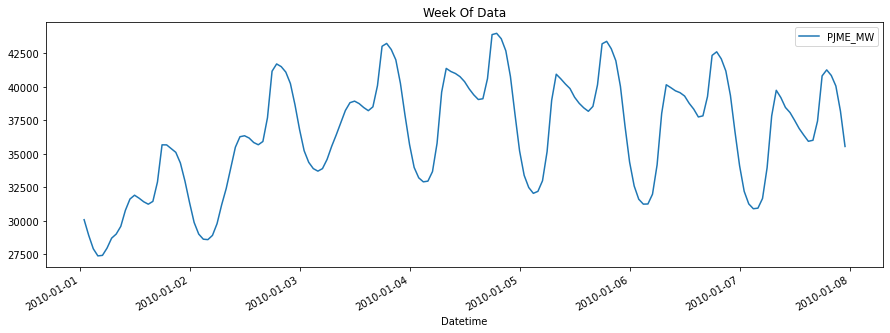

In [10]:
# Plot the energy consumption
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()


Outlier Removal

(array([2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 4.000e+00, 2.000e+00, 7.000e+00, 1.500e+01, 2.200e+01,
        2.100e+01, 3.600e+01, 4.800e+01, 4.300e+01, 6.400e+01, 8.900e+01,
        9.100e+01, 1.100e+02, 1.190e+02, 1.160e+02, 1.440e+02, 1.610e+02,
        1.880e+02, 2.380e+02, 2.120e+02, 2.350e+02, 2.510e+02, 2.910e+02,
        3.220e+02, 3.420e+02, 3.580e+02, 3.560e+02, 3.520e+02, 3.870e+02,
        3.640e+02, 3.600e+02, 3.670e+0

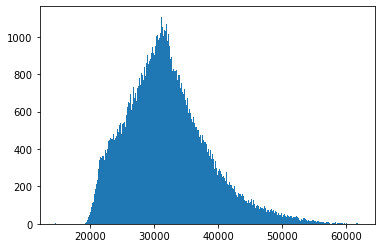

In [11]:
#Plotting the distribution of the energy
plt.hist(df['PJME_MW'], bins=500)

Text(0.5, 1.0, 'Outliers')

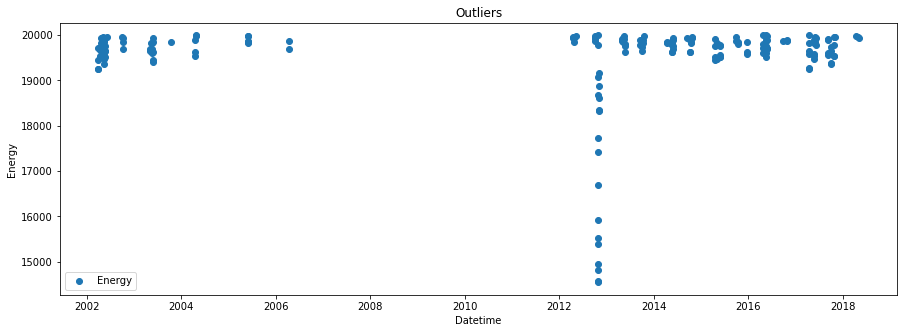

In [12]:
#Plotting the outlier
outlier = df.where(df['PJME_MW']< 20_000)
plt.figure(figsize=(15, 5))
plt.scatter(outlier.index, outlier, label='Energy')
plt.ylabel('Energy')
plt.xlabel('Datetime')
plt.legend()
plt.title('Outliers')

In [13]:
#Saving a df without outliers
df = df.where(df['PJME_MW']>19_000).copy()

Train/Test split

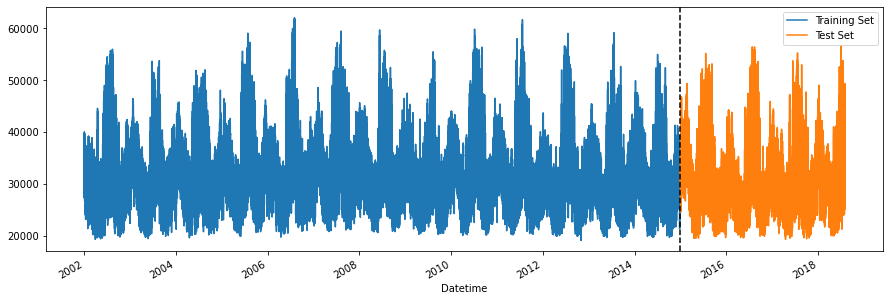

In [14]:
#Splitting the data in 80-20
train=df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

#making subplots
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

K-Fold validation

In [15]:
tes=TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)   #There will be 5 folds and test size will be one year hourly data
df = df.sort_index()

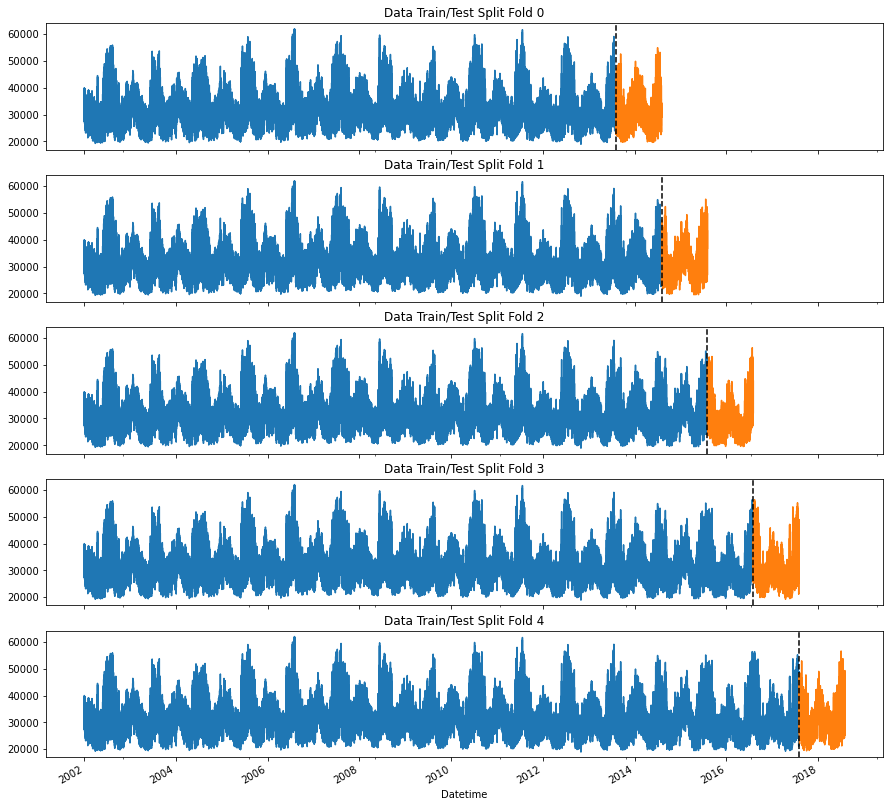

In [16]:
# Create subplots with 5 rows and 1 column, and set the figure size
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0

# Iterate over the train/test splits generated by the TimeSeriesSplit object (tes)
for train_idx, val_idx in tes.split(df):
    # Get the training and test sets for the current fold
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
 
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    
    # Add a vertical line to indicate the boundary between training and test data
    axs[fold].axvline(test.index.min(), color='black', ls='--')

    fold += 1

plt.show()


Create features

In [17]:
#Extracting features like hour, day of week, quarter, month, year and day of year from date-time index
def create_features (df):
        df ['hour'] = df.index.hour
        df ['week'] = df.index.dayofweek
        df['quarter'] = df.index.quarter
        df['month'] = df.index.month
        df['year'] = df.index.year
        df [ 'dayofyear'] = df.index.dayofyear
        return df
        I
df = create_features(df)

Creating rolling Statistics

In [18]:
#Extracting mean and standard deviation for window size of 7
def rolling(df):
    df['rolling_mean_7'] = df['PJME_MW'].rolling(window=7).mean()
    df['rolling_std_7'] = df['PJME_MW'].rolling(window=7).std()
    return df

In [19]:
df = rolling(df)

In [20]:
df

,PJME_MW,hour,week,quarter,month,year,dayofyear,rolling_mean_7,rolling_std_7
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,46278.714286,1095.354389
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,45810.428571,1567.131015
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,45010.142857,2104.805092


Training the model

[0]	validation_0-rmse:32731.02592	validation_1-rmse:31955.37600


<ipython-input-17-1f86fe96da12>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df ['hour'] = df.index.hour
<ipython-input-17-1f86fe96da12>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df ['week'] = df.index.dayofweek
<ipython-input-17-1f86fe96da12>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

[100]	validation_0-rmse:12215.61865	validation_1-rmse:11779.64952
[200]	validation_0-rmse:4850.59406	validation_1-rmse:4604.99926
[300]	validation_0-rmse:2307.91631	validation_1-rmse:2212.24399
[400]	validation_0-rmse:1511.84753	validation_1-rmse:1537.85415
[500]	validation_0-rmse:1248.79950	validation_1-rmse:1348.45602
[600]	validation_0-rmse:1134.68369	validation_1-rmse:1265.64822
[700]	validation_0-rmse:1066.18385	validation_1-rmse:1210.58300
[800]	validation_0-rmse:1020.35494	validation_1-rmse:1170.24304
[900]	validation_0-rmse:982.27127	validation_1-rmse:1133.36059
[999]	validation_0-rmse:948.83958	validation_1-rmse:1097.47675
[0]	validation_0-rmse:32670.59791	validation_1-rmse:32136.00582


<ipython-input-17-1f86fe96da12>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df ['hour'] = df.index.hour
<ipython-input-17-1f86fe96da12>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df ['week'] = df.index.dayofweek
<ipython-input-17-1f86fe96da12>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

[100]	validation_0-rmse:12193.09158	validation_1-rmse:11879.24850
[200]	validation_0-rmse:4842.16285	validation_1-rmse:4666.65917
[300]	validation_0-rmse:2310.80311	validation_1-rmse:2255.23944
[400]	validation_0-rmse:1518.11003	validation_1-rmse:1563.96845
[500]	validation_0-rmse:1257.91289	validation_1-rmse:1360.46868
[600]	validation_0-rmse:1144.20668	validation_1-rmse:1270.27602
[700]	validation_0-rmse:1075.50390	validation_1-rmse:1210.34176
[800]	validation_0-rmse:1030.20998	validation_1-rmse:1168.28758
[900]	validation_0-rmse:992.93602	validation_1-rmse:1129.63737
[999]	validation_0-rmse:959.34943	validation_1-rmse:1093.14310
[0]	validation_0-rmse:32629.41229	validation_1-rmse:31081.27160


<ipython-input-17-1f86fe96da12>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df ['hour'] = df.index.hour
<ipython-input-17-1f86fe96da12>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df ['week'] = df.index.dayofweek
<ipython-input-17-1f86fe96da12>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

[100]	validation_0-rmse:12177.70730	validation_1-rmse:11377.39941
[200]	validation_0-rmse:4838.04665	validation_1-rmse:4396.60491
[300]	validation_0-rmse:2313.81940	validation_1-rmse:2101.29303
[400]	validation_0-rmse:1527.35668	validation_1-rmse:1475.02899
[500]	validation_0-rmse:1268.78692	validation_1-rmse:1291.17318
[600]	validation_0-rmse:1155.39799	validation_1-rmse:1206.27072
[700]	validation_0-rmse:1087.99303	validation_1-rmse:1148.81824
[800]	validation_0-rmse:1041.52525	validation_1-rmse:1105.08939
[900]	validation_0-rmse:1000.79281	validation_1-rmse:1065.53296
[999]	validation_0-rmse:959.16643	validation_1-rmse:1024.13923
[0]	validation_0-rmse:32526.29743	validation_1-rmse:31472.94466


<ipython-input-17-1f86fe96da12>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df ['hour'] = df.index.hour
<ipython-input-17-1f86fe96da12>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df ['week'] = df.index.dayofweek
<ipython-input-17-1f86fe96da12>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

[100]	validation_0-rmse:12140.53421	validation_1-rmse:11623.32446
[200]	validation_0-rmse:4824.52216	validation_1-rmse:4560.54195
[300]	validation_0-rmse:2316.52120	validation_1-rmse:2206.53627
[400]	validation_0-rmse:1530.74831	validation_1-rmse:1518.46708
[500]	validation_0-rmse:1275.14030	validation_1-rmse:1306.43983
[600]	validation_0-rmse:1161.05324	validation_1-rmse:1209.03244
[700]	validation_0-rmse:1092.67690	validation_1-rmse:1146.23778
[800]	validation_0-rmse:1045.58316	validation_1-rmse:1100.71868
[900]	validation_0-rmse:999.81644	validation_1-rmse:1055.87704
[999]	validation_0-rmse:965.20040	validation_1-rmse:1022.28396
[0]	validation_0-rmse:32459.37865	validation_1-rmse:31458.57134


<ipython-input-17-1f86fe96da12>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df ['hour'] = df.index.hour
<ipython-input-17-1f86fe96da12>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df ['week'] = df.index.dayofweek
<ipython-input-17-1f86fe96da12>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

[100]	validation_0-rmse:12116.63808	validation_1-rmse:11616.62854
[200]	validation_0-rmse:4815.59629	validation_1-rmse:4551.54345
[300]	validation_0-rmse:2311.46102	validation_1-rmse:2200.16644
[400]	validation_0-rmse:1529.60032	validation_1-rmse:1542.47241
[500]	validation_0-rmse:1270.25245	validation_1-rmse:1357.94051
[600]	validation_0-rmse:1158.65892	validation_1-rmse:1280.46019
[700]	validation_0-rmse:1091.50039	validation_1-rmse:1229.64713
[800]	validation_0-rmse:1043.68790	validation_1-rmse:1188.74305
[900]	validation_0-rmse:996.15321	validation_1-rmse:1139.69487
[999]	validation_0-rmse:961.45097	validation_1-rmse:1103.99260


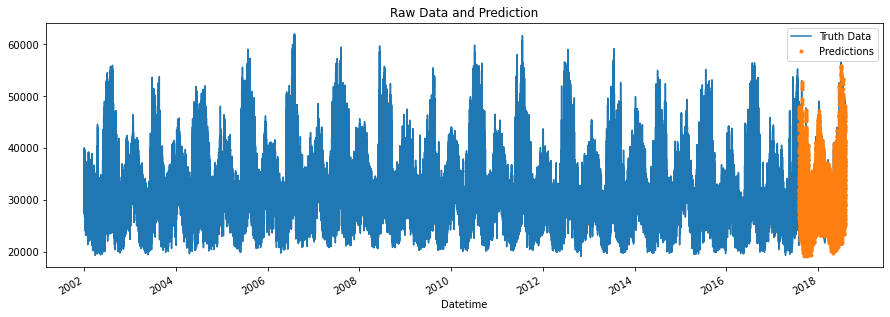

In [21]:
# Ensure the DataFrame is sorted by index
#df = df.sort_index()

# Initialize TimeSeriesSplit with the given parameters
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)
    
    # Drop rows with NaN values in target and features
    train = train.dropna(subset=['PJME_MW', 'dayofyear', 'hour', 'week', 'quarter', 'month', 'year', 'rolling_mean_7', 'rolling_std_7'])
    test = test.dropna(subset=['PJME_MW', 'dayofyear', 'hour', 'week', 'quarter', 'month', 'year', 'rolling_mean_7', 'rolling_std_7'])

    FEATURES = ['dayofyear', 'hour', 'week', 'quarter', 'month', 'year', 'rolling_mean_7', 'rolling_std_7']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    #score = np.sqrt(mean_squared_error(y_test, y_pred))
    #scores.append(score)

    # Align predictions with the test index
    test = test.assign(prediction=y_pred)
    df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Plotting the results
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

# Display scores

#print(f"Scores: {scores}")
#print(f"Mean Score: {np.mean(scores)}")

Feature Importance

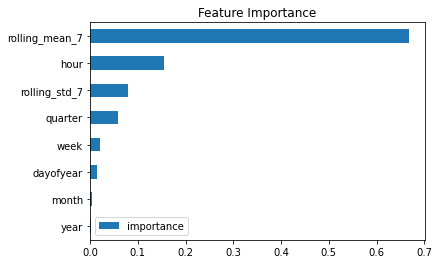

In [22]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Testing the model

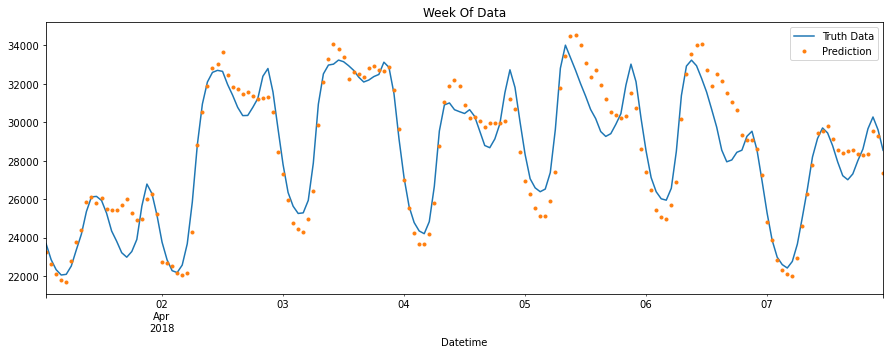

In [23]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

Evaluation

In [24]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

r2 = r2_score(y_test, test['prediction'])
print("R-squared (R2) score:", r2)

RMSE Score on Test set: 1103.99
R-squared (R2) score: 0.9667414784438945


In [33]:
reg.save_model('model.json')